# Parse Data

Run: pip install thesillyhome -e ./thesillyhome/

In [1]:
import thesillyhome.model_creator.read_config_json as tsh_config
import thesillyhome.model_creator.parse_data as parse_data

import numpy as np
import pandas as pd
import json
import sklearn

In [2]:
df = pd.read_pickle('user_data.pkl')

In [3]:
df.head(5)

,id,snapshot_time,get_state_json,type,user_id
0,2,2022-08-18 13:29:49.494421,"{""person.lcmchris"": {""entity_id"": ""person.lcmc...",chng,None
1,13,2022-08-18 13:30:37.813963,"{""person.lcmchris"": {""entity_id"": ""person.lcmc...",chng,None
2,14,2022-08-18 13:30:38.157529,"{""person.lcmchris"": {""entity_id"": ""person.lcmc...",chng,None
3,15,2022-08-18 13:30:38.527251,"{""person.lcmchris"": {""entity_id"": ""person.lcmc...",chng,None
4,16,2022-08-18 13:30:38.872546,"{""person.lcmchris"": {""entity_id"": ""person.lcmc...",chng,None


In [4]:
df = df.drop_duplicates(subset=df.columns.drop(['id','snapshot_time']))
df_normalized = pd.json_normalize(df['get_state_json'].apply(json.loads).to_list())
df_normalized.head(5)

,person.lcmchris.entity_id,person.lcmchris.state,person.lcmchris.attributes.editable,person.lcmchris.attributes.id,person.lcmchris.attributes.latitude,person.lcmchris.attributes.longitude,person.lcmchris.attributes.gps_accuracy,person.lcmchris.attributes.source,person.lcmchris.attributes.user_id,person.lcmchris.attributes.friendly_name,...,light.corridor_light_4.attributes.brightness,light.corridor_light_2.attributes.color_mode,light.corridor_light_2.attributes.brightness,light.corridor_light_3.attributes.color_mode,light.corridor_light_3.attributes.brightness,light.corridor_lights.attributes.color_mode,light.corridor_lights.attributes.brightness,light.bedroom_sidetable_lamp.attributes.color_mode,light.bedroom_sidetable_lamp.attributes.brightness,update.thesillyhome_addon_dev_update.attributes.entity_picture
0,person.lcmchris,home,False,lcmchris,51.542694,-0.001366,22,device_tracker.chris_phone,7565d1f7fc954a4eaee3c6248db2a078,lcmchris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,person.lcmchris,home,False,lcmchris,51.542694,-0.001366,22,device_tracker.chris_phone,7565d1f7fc954a4eaee3c6248db2a078,lcmchris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,person.lcmchris,home,False,lcmchris,51.542694,-0.001366,22,device_tracker.chris_phone,7565d1f7fc954a4eaee3c6248db2a078,lcmchris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,person.lcmchris,home,False,lcmchris,51.542694,-0.001366,22,device_tracker.chris_phone,7565d1f7fc954a4eaee3c6248db2a078,lcmchris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,person.lcmchris,home,False,lcmchris,51.542694,-0.001366,22,device_tracker.chris_phone,7565d1f7fc954a4eaee3c6248db2a078,lcmchris,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
from thesillyhome.model_creator.parse_data import one_hot_encoder

df_parsed = df_normalized.copy()
state_columns = []
for index in df_parsed.columns:
    if 'state' in index:
        state_columns.append(index)

df_parsed = df_parsed[state_columns]
df_parsed = df_parsed.fillna(0)

df_parsed = df_parsed.replace(['off','unavailable','unknown'],0)
df_parsed = df_parsed.replace(['on'],1)

act_columns=[]
for index in df_parsed.columns:
    if index.rsplit('.',1)[0] in tsh_config.actuators:
        act_columns.append(index)

df_act_states = df_parsed[act_columns]

df_sen_states = df_parsed[df_parsed.columns.drop(act_columns)]
df_sen_states = df_sen_states[df_sen_states.columns[df_sen_states.nunique() > 1]]

for column in df_sen_states.columns[df_sen_states.dtypes=='object']:
    try:
        df_sen_states[column] = df_sen_states[column].astype(np.int64)
    except:
        continue

for column in df_sen_states.columns[df_sen_states.dtypes=='object']:
    df_sen_states = one_hot_encoder(df_sen_states,column)


In [20]:
X = df_sen_states.astype(np.float32)
Y = df_act_states.astype(np.float32)
ratio = int(len(X)*0.8)


(X_train,X_test,Y_train,Y_test) = X[:ratio], X[ratio:],Y[:ratio], Y[ratio:]

# Model testing

In [21]:
import matplotlib.pyplot as plt
from tensorflow import keras

Epoch 1/50
70/70 [==============================] - 1s 2ms/step - loss: 2.4902 - binary_accuracy: 0.7405
Epoch 2/50
70/70 [==============================] - 0s 2ms/step - loss: 0.6039 - binary_accuracy: 0.8243
Epoch 3/50
70/70 [==============================] - 0s 2ms/step - loss: 0.4837 - binary_accuracy: 0.8422
Epoch 4/50
70/70 [==============================] - 0s 2ms/step - loss: 0.3870 - binary_accuracy: 0.8670
Epoch 5/50
70/70 [==============================] - 0s 2ms/step - loss: 0.3466 - binary_accuracy: 0.8816
Epoch 6/50
70/70 [==============================] - 0s 2ms/step - loss: 0.3197 - binary_accuracy: 0.8915
Epoch 7/50
70/70 [==============================] - 0s 2ms/step - loss: 0.2874 - binary_accuracy: 0.9014
Epoch 8/50
70/70 [==============================] - 0s 2ms/step - loss: 0.2643 - binary_accuracy: 0.9026
Epoch 9/50
70/70 [==============================] - 0s 2ms/step - loss: 0.2570 - binary_accuracy: 0.9115
Epoch 10/50
70/70 [==============================] - 0s

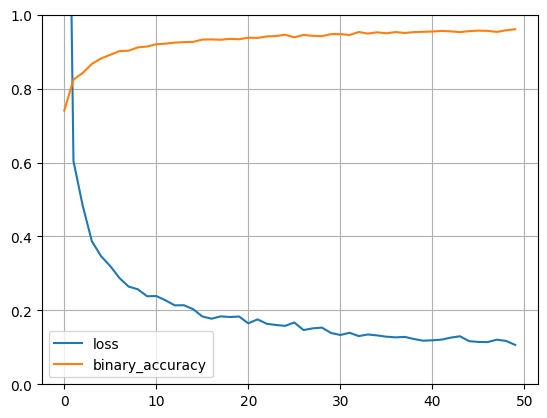

9/9 [==============================] - 0s 2ms/step - loss: 0.6002 - binary_accuracy: 0.8819


[0.6002329587936401, 0.8818979263305664]

In [22]:
## Model 1
model_dnn = keras.models.Sequential()
model_dnn.add(keras.layers.Dense(50,activation='relu'))
model_dnn.add(keras.layers.Dropout(0.2))
model_dnn.add(keras.layers.Dense(50,activation='relu'))
model_dnn.add(keras.layers.Dropout(0.2))
model_dnn.add(keras.layers.Dense(50,activation='relu'))
model_dnn.add(keras.layers.Dropout(0.2))
model_dnn.add(keras.layers.Dense(len(Y.columns),activation='sigmoid'))

nadam = keras.optimizers.Nadam(learning_rate=0.001)
model_dnn.compile(loss='binary_crossentropy',optimizer=nadam,metrics='binary_accuracy')
history = model_dnn.fit(X_train,Y_train, epochs=50,batch_size=16)

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

model_dnn.evaluate(X_test,Y_test)

In [27]:
Y_train_shifted = Y_train.shift(1)
Y_test_shifted = Y_test.shift(1)

In [31]:
X_test.head(5)

,update.home_assistant_core_update.state,update.home_assistant_operating_system_update.state,zone.home.state,sensor.chris_phone_battery_level.state,binary_sensor.chris_phone_is_charging.state,sensor.bedroom_entrance_sensor_battery.state,sensor.bedroom_entrance_sensor_illuminance_lux.state,sensor.bedroom_entrance_sensor_device_temperature.state,sensor.livingroom_desk_switch_battery.state,sensor.livingroom_desk_sensor_illuminance_lux.state,...,weather.home.state_partlycloudy,weather.home.state_rainy,weather.home.state_sunny,sensor.livingroom_desk_switch_action.state_,sensor.livingroom_desk_switch_action.state_None,sensor.livingroom_entrance_switch_action.state_,sensor.livingroom_entrance_switch_action.state_None,sensor.livingroom_entrance_switch_action.state_single_right,sensor.livingroom_deskchair_sensor_action.state_,sensor.livingroom_deskchair_sensor_action.state_None
1106,1.0,0.0,1.0,54.0,0.0,50.0,20.0,33.0,71.0,37.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1107,1.0,0.0,1.0,54.0,0.0,50.0,20.0,33.0,71.0,37.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1108,1.0,0.0,1.0,54.0,0.0,50.0,20.0,33.0,71.0,37.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1109,1.0,0.0,1.0,54.0,0.0,50.0,20.0,33.0,71.0,37.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1110,1.0,0.0,1.0,54.0,0.0,50.0,23.0,33.0,71.0,37.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [29]:
Y_test_shifted.head(5)

,switch.livingroom_entrance_switch_left.state,switch.livingroom_entrance_switch_center.state,switch.livingroom_entrance_switch_right.state,light.bedroom_sidetable_lamp.state,light.bedroom_ceiling_light.state,light.corridor_lights.state,light.bathroom_lights.state
1106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1107,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1108,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1109,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1110,1.0,1.0,1.0,1.0,0.0,0.0,1.0


Epoch 1/50
138/138 [==============================] - 11s 17ms/step - loss: 0.3442 - last_time_binary_accuracy: 0.7596
Epoch 2/50
138/138 [==============================] - 2s 17ms/step - loss: 0.3120 - last_time_binary_accuracy: 0.7572
Epoch 3/50
138/138 [==============================] - 3s 18ms/step - loss: 0.3091 - last_time_binary_accuracy: 0.7591
Epoch 4/50
138/138 [==============================] - 3s 18ms/step - loss: 0.2827 - last_time_binary_accuracy: 0.7636
Epoch 5/50
138/138 [==============================] - 3s 19ms/step - loss: 0.3033 - last_time_binary_accuracy: 0.7862
Epoch 6/50
138/138 [==============================] - 3s 18ms/step - loss: 0.3020 - last_time_binary_accuracy: 0.7663
Epoch 7/50
138/138 [==============================] - 3s 19ms/step - loss: 0.2892 - last_time_binary_accuracy: 0.7645
Epoch 8/50
138/138 [==============================] - 3s 18ms/step - loss: 0.2939 - last_time_binary_accuracy: 0.7645
Epoch 9/50
138/138 [==============================] - 3

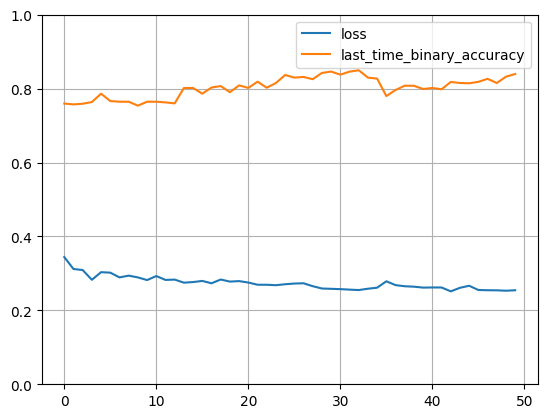

35/35 [==============================] - 1s 7ms/step - loss: 0.4060 - last_time_binary_accuracy: 0.7536


[0.4059685170650482, 0.7535714507102966]

In [41]:
## Model 2
n_features = X.shape[1]
n_input = 3
batch_size = 8
model_rnn = keras.models.Sequential()
model_rnn.add(keras.layers.LSTM(50,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(keras.layers.LSTM(50,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(keras.layers.Dense(len(Y.columns)))

Y_train_shifted = Y_train.shift(1)
Y_test_shifted = Y_test.shift(1)

generator_train = keras.preprocessing.sequence.TimeseriesGenerator(X_train.values,Y_train_shifted.values,
                               length=n_input,
                               batch_size=batch_size)
generator_test = keras.preprocessing.sequence.TimeseriesGenerator(X_test.values,Y_test_shifted.values,
                               length=n_input,
                               batch_size=batch_size)


nadam = keras.optimizers.Nadam(learning_rate=0.005)
loss = keras.losses.BinaryCrossentropy(from_logits=True)

def last_time_binary_accuracy(Y_true, Y_pred):
  return keras.metrics.binary_accuracy(Y_true[:, -1], Y_pred[:, -1])


model_rnn.compile(loss=loss,optimizer=nadam,metrics=last_time_binary_accuracy)
history = model_rnn.fit(generator_train, epochs=50)

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

model_rnn.evaluate(generator_test)